In [117]:
# coding: utf-8

# In[1]:

import cv2
import io
import os
from os.path import exists
import sys
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchvision import models, datasets, transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.image as mpimg
import pandas as pd
import matplotlib.pyplot as plt
import collections
from PIL import ImageDraw 
import random
import re
from IoU import *
from ram import ReplayBuffer
from Network import QNetwork, BboxReg, CLS
from action import *

#----------------read data-----------------------
def Str2np(target):
    num = re.sub(r'\D', " ", target)
    a = np.fromstring(num, dtype=int, sep=' ')
    return a

def ReadData(csv_dir, img_dir, image_sets , test = None):
    imgs = []
    if test is not None:
        train_filename = csv_dir+'/val.csv'
    else:
        train_filename = csv_dir + '/train.csv'

    data = pd.read_csv(train_filename)
    name = data.fname.values
    child = data.child.values
    for i, entry in enumerate(name):
        pack = child[i]
        imgs.append([entry, Str2np(pack)])
    return imgs

root_dir =  '/home/minty/dataset/VOCdevkit/VOC2012/'
csv_dir = os.path.join(root_dir,'src')
img_dir = os.path.join(root_dir,'JPEGImages')
image_sets =  ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat',      'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',       'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
imgs = ReadData(csv_dir,img_dir,image_sets, test = None)
test_imgs = ReadData(csv_dir,img_dir,image_sets, test = True)
input_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                        std = [ 0.229, 0.224, 0.225 ]),
])

class Data(data.Dataset):
    def __init__(self, imgs, image_sets,  input_transform = None,                  target_transform = None ,test = None):
        self.test = test
        self.input_transform = input_transform
        self.target_transform = target_transform
        self.classes = len(image_sets)
        self.imgs = imgs

    def __getitem__(self, index):
        fn, pack = self.imgs[index]
        img = Image.open(img_dir + '/' +fn).convert('RGB')
        if self.input_transform is not None:
            img = self.input_transform(img)
        return img, pack, fn

    def __len__(self):
        return len(self.imgs)

#-----------------read data------------------------------#
img_data = Data(imgs, image_sets, input_transform = input_transform, target_transform=None                , test=None)
test_data = Data(test_imgs, image_sets, input_transform = input_transform, target_transform=None                , test=None)
print(len(img_data.imgs), len(test_data.imgs))
img_batch = data.DataLoader(img_data, batch_size=1 ,shuffle=True, num_workers = 2)
test_batch = data.DataLoader(test_data, batch_size=1 ,shuffle=False, num_workers = 2) 


# In[2]:

#---------hyper parameters---------#
gamma = 0.90
epsilon = 1
num_his = 20
trans_dim = 9
scale_dim = 10
state_dim1 = scale_dim * num_his + 4096
state_dim2 = trans_dim * num_his + 4096
critic_lr = 0.001
actor_lr = 0.01
tau = 0.001
random_seed = 1234
max_step = 35
iou_threshold = 0.5
minibatch_size = 64
#---------Net-----------#
vgg = models.vgg19(pretrained = True)
class VGG(nn.Module):
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.roi = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(512, 21)

    def forward(self, x):
        x = self.roi(self.features(x))
        x = x.view(-1)
        x = self.classifier(x)
        return F.softmax(x)

boxclass = torch.load('cls12.pth')
vgg = torch.load('vgg_roi_class_net3.pth')
Extractor = nn.Sequential(*list(vgg.features.children())[:-5]).cuda()
loss_func = nn.MSELoss()
loss_fun1 = nn.SmoothL1Loss()
target1 = torch.load('model1_19.pth')#QNetwork(state_dim1, scale_dim).cuda()
target2 = torch.load('model2_19.pth')
model1 = torch.load('model1_19.pth')
model2 = torch.load('model2_19.pth')
print "model loaded..."


# In[3]:

def Transition(box, feature):
    if int(box[3])+1 <= int(box[1]) or int(box[2])+1 <= int(box[0]):
        return None
    x_img = feature[:, :, int(box[1]):int(box[3])+1, int(box[0]):int(box[2])+1]
    return x_img

def _whctrs(anchor):
    w = anchor[2] - anchor[0] + 1
    h = anchor[3] - anchor[1] + 1
    x_ctr = anchor[0] + 0.5 * (w - 1)
    y_ctr = anchor[1] + 0.5 * (h - 1)
    return w, h, x_ctr, y_ctr

def Initial(im_shape, init, fn):
    grad = init[fn[0]]
    trans = np.array([0, 0, im_shape[0], im_shape[1]]) #global inittialization
    box_a = np.vstack((trans, grad))    
    return torch.from_numpy(box_a).float()

def Clip_boxes(box, im_shape):
    #print box
    box[0] = np.maximum(np.minimum(box[0], im_shape[0] - 1), 0)
    box[1] = np.maximum(np.minimum(box[1], im_shape[1] - 1), 0)
    box[2] = np.maximum(np.minimum(box[2], im_shape[0] - 1), 0)
    box[3] = np.maximum(np.minimum(box[3], im_shape[1] - 1), 0)
    new_box = torch.FloatTensor([box[0], box[1], box[2], box[3]])
    return new_box

def GetState(box, history_vector, feature):
    box_img = Transition(box, img)
    roi_pooling = nn.AdaptiveAvgPool2d((2, 2))
    state1 = roi_pooling(Extractor.forward(Variable(img, volatile = True).cuda())).view(-1)
    state2 = roi_pooling(feature).view(-1)
    state3 = Variable(torch.from_numpy(history_vector)).view(-1).float().cuda()
    state = torch.cat((state1, state2, state3), 0).unsqueeze(0)
    return state

def GetSample(box1, box2):
    x = np.array([box1[0], box1[2], box2[0], box2[2]])
    y = np.array([box1[1], box1[3], box2[1], box2[3]])
    x = np.sort(x)
    y = np.sort(y)
    #new_box = np.array((36, 4))
    nx = np.zeros((6, 2))
    ny = np.zeros((6, 2))
    point = 0
    for i in range(3):
        for j in range(i+1, 4):
            nx[point, 0] = x[i]
            nx[point, 1] = x[j]
            ny[point, 0] = y[i]
            ny[point, 1] = y[j]
            point += 1
    new_box = torch.zeros((36, 4))
    point = 0
    for i in range(6):
        for j in range(6):
            w,h ,ctrx, ctry = _whctrs([nx[i, 0], ny[j, 0], nx[i, 1], ny[j, 1]])
            new_box[i] = _mkanchors(w, h, ctrx, ctry)
    return new_box

def GetRandom(record):
    num = len(record)
    #x = np.random.randint(int(num / 3), int(num/2))
    x = int(num/2)
    y = np.array(random.sample(range(1, num), x))
    z = num - y
    box_1 = np.zeros((x, 4))
    box_2 = np.zeros((x, 4))
    for i in range(x):
        box_1[i] = record[y[i]][0]
        box_2[i] = record[z[i]][0]
    new_box_a = torch.zeros((36*x, 4))
    for i in range(x):
        new_box_a[i*36: (i+1)*36] = GetSample(box_1[i], box_2[i])
    return new_box_a


# In[4]:

def _mkanchors(ws, hs, x_ctr, y_ctr):
    anchors = np.array((x_ctr - 0.5 * (ws - 1),
                         y_ctr - 0.5 * (hs - 1),
                         x_ctr + 0.5 * (ws - 1),
                         y_ctr + 0.5 * (hs - 1)))
    #print anchors
    return torch.from_numpy(anchors).float()

def GenerateAnchor(box, im_shape):
    box_ = torch.FloatTensor(4, 4)
    w,h, ctr_x, ctr_y = _whctrs(box)
    box_[0] = box
    box_[1] = Clip_boxes(_mkanchors(h, w, ctr_x, ctr_y), im_shape)
    box_[2] = Clip_boxes(_mkanchors(max(w, h), max(w, h), ctr_x, ctr_y), im_shape)
    box_[3] = Clip_boxes(_mkanchors(min(w, h), min(w, h), ctr_x, ctr_y), im_shape)
    return box_


# In[4]:

def Sample(box, action, history_vector, record, Step, action_dim):
    reward = 0.
    terminal = 0.
    im_shape = np.array([img.size(3), img.size(2)])
    anchors = GenerateAnchor(box.squeeze(0), im_shape)
    new_iou, deltas, loc = IoUList(anchors, ground_truth, record)
    box = anchors[int(loc)]
    if max(deltas) > 0.:
        reward += 10 * max(deltas)
    else:
        reward -= 1.0
    #-------update history vector----#
    his = np.zeros(action_dim)
    his[action] = 1
    if Step < num_his:
        history_vector[Step][action] = 1
    else:
        history_vector = np.vsplit(history_vector, np.array([1, num_his]))[1]
        history_vector = np.vstack((history_vector, his))
    
    area = im_shape[0] * im_shape[1]
    w, h, ctrx, ctry = _whctrs(box)
    if w * h < area / 100 or w < 32 or h < 32 or Step > max_step:
        terminal = 1.
        
    if terminal == 1. :
        return None, None, terminal, new_iou, None, Step, box
    else:
        next_state = GetState(box.squeeze(0), history_vector, feature)
        Step += 1
        return next_state, reward, terminal, new_iou, history_vector, Step, box

def IoUList(box, ground_truth, record, mode = 'Multi'):  #return new iou result and the amount of change
    num = ground_truth.size(0)
    if isinstance(box, np.ndarray):
        m = box.shape[0]
    else:
        m = box.size(0)
    if mode == 'Multi':
        iou_result = np.zeros((num, m))
        result = np.zeros(num)
        loc = np.zeros(num)
        deltas = np.zeros(num)
        for i in range(num):
            for j in range(m):
                iou_result[i][j] = IoU(box[j], ground_truth[i])
            result[i] = max(iou_result[i])
            loc[i] = np.argmax(iou_result[i])
        return result, deltas, loc[np.argmax(result)]
    else: #'single'
        iou_result = np.zeros(num)
        loc = 0
        for i in range(num):
            iou_result[i] = IoU(box, ground_truth[i])
        loc = np.argmax(iou_result)
        return iou_result, loc


# In[5]:

def WriteRecord(epoch_record, epoch, mode = 'record_'):
    f = open('./checkpoints/thre2/model_'+ mode  + str(epoch) +'.txt', 'w')
    for i in range(len(epoch_record)):
        name, result = epoch_record[i]
        f.write(name + ' ')
        for j in range(result.shape[0]):
            box = result[j, 0:4]
            iou = result[j, 4]
            score = result[j, 5]
            for num in box:
                f.write(str(num) + ',')
            f.write(str(iou) + ',' + str(score) + ' ')
        f.write('\n')

def FindMax(img_record):
    #Step = img_record.shape[0]
    Step = len(img_record)
    box = np.zeros([Step, 6])
    for i in xrange(Step):
        box[i][:4] = img_record[i][0]
        box[i][4] = img_record[i][1]
        box[i][5] = img_record[i][2]
    box=box[box[:,4].argsort()]
    if box.shape[0] == 1:
        return box
    else:
        return box[-1]

def Mean(record):
    iou = []
    for i in range(len(epoch_record)):
        name, result = epoch_record[i]
        iou.append(result[4])
    return np.mean(iou)

def GetClass(record):
    label = np.zeros([len(record), 2])
    iou = np.zeros(len(record))
    for item in range(len(record)):
        iou[item] = record[item][1]
    maxiou = np.argmax(iou)
    for i in range(len(record)):
        if iou[i] > 0.5:
            label[i][0] = 1
        elif iou[i] < 0.3:
            label[i][1] = 1
        else:
            label[i, 0] = -1
    label[maxiou][0] = 1
    label[maxiou][1] = 0
    return label

def GetInput(record, label):
    Step = len(record)
    box = np.zeros([Step, 4])
    point = []
    f = vgg.features(Variable(img).cuda())
    for i in xrange(Step):
        box[i] = record[i][0]
        w, h, cx, cy = _whctrs(box[i])
        while w < 40.:
            box[i] = Clip_boxes(_mkanchors(w + 10., h, cx, cy), im_shape).numpy()
            w, h, cx, cy = _whctrs(box[i])
        while h < 40.:
            box[i] = Clip_boxes(_mkanchors(w, h + 10.0, cx, cy), im_shape).numpy()
            w, h, cx, cy = _whctrs(box[i])
        record[i][0] = box[i]
        if label[i, 0] == -1.:
            point.append(i)
    if len(point) != 0:
        label = np.delete(label, point, axis = 0) 
        record = np.delete(record, point, axis = 0)
    count = np.nonzero(label[:, 0])[0]
    if count.shape[0] == 0:
        print 'No Positive'
    num = 3 * count.shape[0]
    Step = label.shape[0]
    if 4 * count.shape[0] > Step:
        tmp = random.sample(range(0, count.shape[0]), int(Step / 4))
        count = count[tmp]
        num = 3 * count.shape[0]
    l = np.arange(0, label.shape[0])
    l = np.delete(l, count, axis = 0)
    pick = random.sample(range(0, l.shape[0]), num)
    l = l[pick]
    label = np.vstack((label[l], label[count]))
    record = np.vstack((np.array(record)[l], np.array(record)[count]))
    if label.shape[0] == 0:
        print 'label shape is 0...'
        print l, count, record.shape[0], num, Step
    fff = Variable(torch.FloatTensor(record.shape[0], 512)).cuda()
    for i in xrange(record.shape[0]):
        fff[i] = GetFeature(record[i][0], f)
    return record, fff, Variable(torch.from_numpy(label)).float().cuda()

roi = nn.AdaptiveAvgPool2d((1, 1))
def GetFeature(box, f):
    box = Projection_inv(box, img, f)
    box_f = Transition(box, f)
    if box_f is None:
        return Variable(torch.zeros(512)).cuda()
    box_f = roi(box_f).view(-1)
    return box_f#.unsqueeze(0)

def FindThre(img_record, criterion = 'Score', thre = 0.5):
    #Step = img_record.shape[0]
    Step = len(img_record)
    box = np.zeros([Step, 6])
    for i in xrange(Step):
        box[i][:4] = img_record[i][0]
        box[i][4] = img_record[i][1]
        if criterion == 'Score':
            box[i][5] = img_record[i][2]
    if criterion == 'IoU':
        box=box[box[:,4].argsort()]
    else:
        box=box[box[:,5].argsort()]
    for i in range(Step):
        if box[i, 4] > thre:
            break
    return box[i:]
    #i = int(Step / 2)
    #return NMS(box[i:])

def NMS(box, thre):
    #if not isinstance(box, np.ndarray):
    #    box = box.numpy()
    box = box[::-1]
    num = box.shape[0]
    point = []
    flag = 0
    while flag < (num-1):
        mbox = box[flag, :4]
        point = []
        for i in range(flag+1, num):
            if IoU(box[i, :4], mbox) > thre:
                point.append(i)
        box = np.delete(box, point, axis = 0) 
        num = box.shape[0]
        flag += 1
    return box

def _whctrs(anchor):
    w = anchor[2] - anchor[0] + 1
    h = anchor[3] - anchor[1] + 1
    x_ctr = anchor[0] + 0.5 * (w - 1)
    y_ctr = anchor[1] + 0.5 * (h - 1)
    return w, h, x_ctr, y_ctr

def ReadRecord(name, num):
    with open(name) as f:
        lines = f.readlines()
    fn={}
    box = np.zeros(num)
    for line in lines:
        name = line.split(' ')[0]
        t = line.split(' ')[1]+','+line.split(' ')[2]+','+line.split(' ')[3]+','+line.split(' ')[4]
        box = np.fromstring(t, dtype=float, sep=',')
        fn[name] = box
    return fn
init = ReadRecord('./checkpoints/init_record_2012_train.txt', 4)

(5717, 5823)
model loaded...


In [36]:
def PlotBox1(name, box, color):
    img = Image.open(img_dir + '/' + name[0])
    #plt.axis('off')
    draw = ImageDraw.Draw(img)
    if isinstance(box, np.ndarray):
        num = box.shape[0]
    else:
        num = box.size(0)
    for i in range(num):
        box_ = (box[i][0], box[i][1], box[i][2], box[i][3])
        draw.rectangle(box_, outline = color)  
    plt.imshow(img)
    plt.show()
    
def PlotInter(name, img_record,color,k):
    img = Image.open(img_dir + '/' + name[0])
    Step = len(img_record)
    box = np.zeros([Step, 4])
    for i in xrange(Step):
        box[i][:4] = img_record[i][0]
    #plt.imshow(img)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(img, aspect='equal')
    num = box.shape[0]
    #plt.imshow(img_e)
    
    for i in range(num):
        if i < num / 4:
            alpha = 0.25
        elif num/4 <= i < num /2:
            alpha = 0.5
        elif num/2 <= i < 3*num / 4:
            alpha = 0.75
        else:
            alpha = 1
        box_= (box[i][0], box[i][1], box[i][2], box[i][3])
        ax.add_patch(
        plt.Rectangle((box_[0], box_[1]),
                      box_[2] - box_[0],
                      box_[3] - box_[1], fill=False,
                      edgecolor=color, linewidth=4.0, alpha=alpha)
        )
        
    """result = FindMax(img_record)
    box1= (result[0], result[1], result[2], result[3])
    
    #fig, ax = plt.subplots(figsize=(12, 12))
    ax.add_patch(
    plt.Rectangle((box1[0], box1[1]),
                  box1[2] - box1[0],
                  box1[3] - box1[1], fill=False,
                  edgecolor='green', linewidth=3.5)
    )
    ax.text(box1[0], box1[1] - 2,
            'score: {:.3f}'.format(result[5]),
            bbox=dict(facecolor='blue', alpha=0.5), fontsize=14, color='white')"""
    plt.axis('off')
    plt.tight_layout()
    plt.draw()
    plt.savefig('./checkpoints/record'+str(k)+'.png',bbox_inches='tight')
    plt.show()

def PlotBoxes(name, img_record, color, mode = '0'):
    img = Image.open(img_dir + '/' + name[0])
    Step = len(img_record)
    box = np.zeros([Step, 4])
    for i in xrange(Step):
        box[i][:4] = img_record[i][0]
    #plt.axis('off')
    draw = ImageDraw.Draw(img)
    PlotBox1(name, box, 'red')
    if mode == '1':
        result = FindMax(img_record)
        PlotBox(name, result[:4],'green')
    #draw.rectangle((0,0, box[2], box[3]), outline = 'red')  
    plt.imshow(img)
    plt.show()
    
def PlotBox(name, box, color):
    img = Image.open(img_dir + '/' + name[0])
    #plt.axis('off')
    draw = ImageDraw.Draw(img)
    box_ = (box[0], box[1], box[2], box[3])
    draw.rectangle(box_, outline = color)  
    plt.imshow(img)
    plt.show()

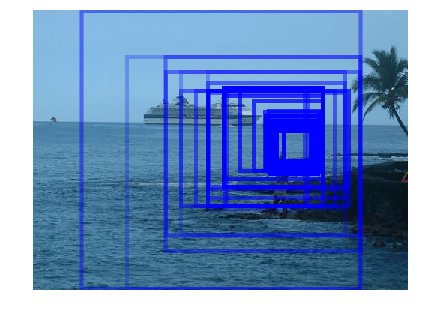

In [72]:
PlotInter(fn, img_record1,'b',0)

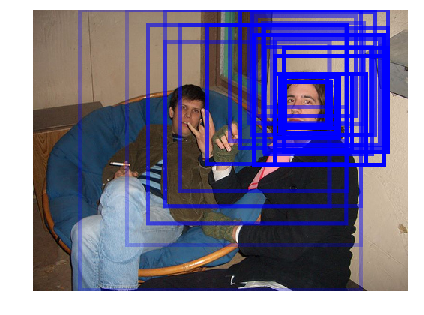

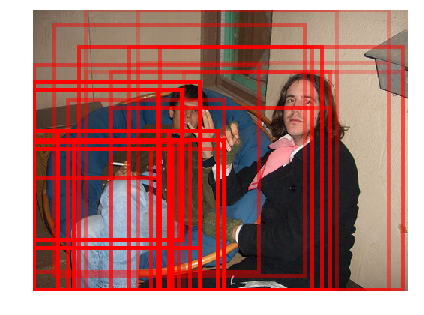

In [147]:
loss_his1 = []
loss_his2 = []
#roi_pooling = nn.AdaptiveAvgPool2d((3, 3))
thre = 0.5
#optimizer_c = torch.optim.SGD(boxclass.parameters(), lr=0.0001)  
#roi_pooling = nn.AdaptiveAvgPool2d((10,10))
epoch_record = []
for step, (img, pack, fn) in enumerate(img_batch):
    num = int(pack.size(1) / 5)
    #----parameters initializing-----------#
    ground_truth = torch.FloatTensor(num, 4)
    cls = torch.LongTensor(num)
    pack = pack.squeeze(0)
    im_shape = np.array([img.size(3), img.size(2)])
    feature = Extractor.forward(Variable(img).cuda())
    feature_shape = np.array([feature.size(3), feature.size(2)])
    #-----record the gt and cls------#
    for j in xrange(num):
        ground_truth[j] = pack[5*j: 5*j+4].clone()
        cls[j] = pack[5*j+4]
    #--------initialization---------#
    img_record = []
    img_record1 = []
    img_record2 = []
    box_a = Initial(im_shape, init, fn)
    for k in range(2): #2 initialization
        Step = 0
        terminal = 0.
        if k == 0:
            history_vector = np.zeros((num_his, scale_dim))
        else:
            history_vector = np.zeros((num_his, trans_dim))
        record = np.zeros(num)
        box_ = box_a[k]
        anchors = GenerateAnchor(box_.squeeze(0), im_shape)
        new_iou, deltas, loc = IoUList(anchors, ground_truth, record)
        box_ = anchors[int(loc)]
        s = GetState(box_, history_vector, feature)
        learn_step = 0
        record = new_iou
        img_record.append([box_.numpy(), max(record)])
        if k == 0:
            img_record1.append([box_.numpy(), max(record)])
        else:
            img_record2.append([box_.numpy(), max(record)])
        while(k == 0 and terminal == 0.):
            #-----get action------#
            if random.random() < epsilon:
                action = np.random.randint(0, 9)
            else:
                output = model1.forward(s)
                action = torch.max(output.data, 1)[1].cpu().numpy()[0]
            #-------------#sample the action------#
            box = Generate(action, box_.squeeze(0), 'Scale')
            box = Clip_boxes(box.squeeze(0), im_shape)
            s2, r, terminal, record, history_vector, Step, box = Sample(box, action, history_vector, record, Step, scale_dim)
            if terminal == 1.:
                break              
            #-------update state and box---#
            box_ = box.clone()
            s = s2
            img_record.append([box_.numpy(), max(record)])
            img_record1.append([box_.numpy(), max(record)])

        while(k == 1 and terminal == 0.):
            #-----get action------#
            if random.random() < epsilon:
                action = np.random.randint(0, 8)
            else:
                output = model2.forward(s)
                action = torch.max(output.data, 1)[1].cpu().numpy()[0]
            #-------------#sample the action------#
            box = Generate(action, box_.squeeze(0), 'Trans')
            box = Clip_boxes(box.squeeze(0), im_shape)
            s2, r, terminal, record, history_vector, Step, box = Sample(box, action, history_vector, record, Step, trans_dim)
            if terminal == 1.:
                break
            #-------update state and box---#
            box_ = box.clone()
            s = s2
            img_record.append([box_.numpy(), max(record)])   
            img_record2.append([box_.numpy(), max(record)])
        if k == 0:
            PlotInter(fn,img_record1,'b',k)
        else:
            PlotInter(fn, img_record2,'r',k)
    break

In [154]:
img_record = []
img_record = img_record1+img_record2
new = GetRandom(img_record)
for t in range(new.size(0)):
    new_iou, _ = IoUList(new[t], ground_truth,0, mode ='single')
    if max(new_iou) > 0.5:
        img_record.append([new[t].numpy(), max(new_iou)])                 
label = GetClass(img_record)
record, box_img, label = GetInput(img_record, label)
label_output = boxclass(box_img)
record = np.hstack((record, np.expand_dims(label_output[:,0].data.cpu().numpy(), axis = 1)))
#PlotBoxes(fn, img_record, 'red', '1')
result = FindThre(record, 'IoU', 0.7)
#print result
result = NMS(result, 0.7)
print result
epoch_record.append([fn[0], result])


[[  46.18827057  119.84568024  254.15432739  374.            0.8923701
     0.        ]
 [ 139.           71.          474.          374.            0.85037545
     0.        ]
 [ 103.49999237   82.00000763  395.5         374.            0.77869457
     0.        ]
 [   0.           73.65739441  300.34259033  349.78704834    0.75905954
     0.        ]]


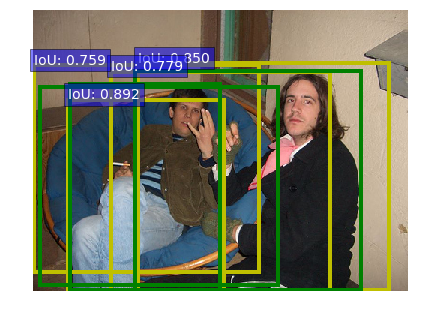

In [155]:
#print record
PlotResult(fn, result,ground_truth, 'y', 2)

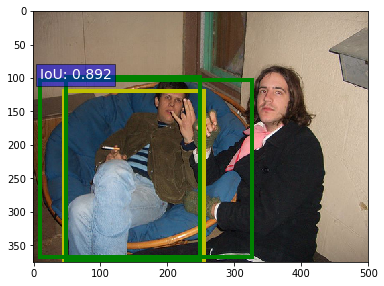

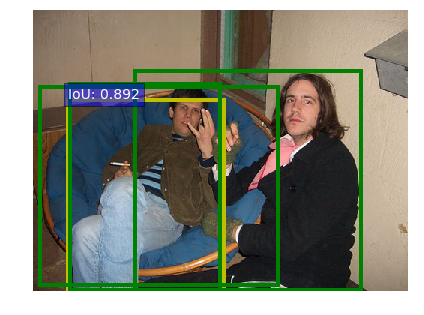

In [153]:
def PlotResult(name, img_record,gt, color,k):
    img = Image.open(img_dir + '/' + name[0])
    Step = len(img_record)
    box = np.zeros([Step, 4])
    for i in xrange(Step):
        box[i][:4] = img_record[i, :4]
    #plt.imshow(img)
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(img, aspect='equal')
    num = box.shape[0]

    for i in range(num):
        box_= (box[i][0], box[i][1], box[i][2], box[i][3])
        ax.add_patch(
        plt.Rectangle((box_[0], box_[1]),
                      box_[2] - box_[0],
                      box_[3] - box_[1], fill=False,
                      edgecolor=color, linewidth=4.0)
        )
        ax.text(box_[0], box_[1] - 2,
        'IoU: {:.3f}'.format(img_record[i][-2]),
        bbox=dict(facecolor='blue', alpha=0.5), fontsize=14, color='white')
    #result = FindMax(img_record)
    for j in range(gt.size(0)):
        box1= (gt[j][0], gt[j][1], gt[j][2], gt[j][3])

        #fig, ax = plt.subplots(figsize=(12, 12))
        ax.add_patch(
        plt.Rectangle((box1[0], box1[1]),
                      box1[2] - box1[0],
                      box1[3] - box1[1], fill=False,
                      edgecolor='green', linewidth=4.0)
        )
    plt.axis('off')
    plt.tight_layout()
    plt.draw()
    plt.savefig('./checkpoints/result'+str(k)+'.png',bbox_inches='tight')
    plt.show()
#result = FindThre(img_record, 'IoU', thre)
#result = NMS(result, 0.7)
PlotResult(fn, result,ground_truth, 'y',2)

In [43]:
print result

[[  58.91899872   86.82217407  440.08099365  412.            0.84228054
     0.        ]]


In [23]:
import cv2
import io
import os
from os.path import exists
import sys
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchvision import models, datasets, transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.image as mpimg
import pandas as pd
import matplotlib.pyplot as plt
import collections
from PIL import ImageDraw 
import random
import re
from IoU import *
from ram import ReplayBuffer
from Network import QNetwork, BboxReg, CLS
from action import *
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
#----------------read data-----------------------
def Str2np(target):
    num = re.sub(r'\D', " ", target)
    a = np.fromstring(num, dtype=int, sep=' ')
    return a

def ReadData(csv_dir, img_dir, image_sets , test = None):
    imgs = []
    if test is not None:
        train_filename = csv_dir+'/val.csv'
    else:
        train_filename = csv_dir + '/train.csv'

    data = pd.read_csv(train_filename)
    name = data.fname.values
    child = data.child.values
    for i, entry in enumerate(name):
        pack = child[i]
        imgs.append([entry, Str2np(pack)])
    return imgs

root_dir =  '/home/minty/dataset/VOCdevkit/VOC2012/'
csv_dir = os.path.join(root_dir,'src')
img_dir = os.path.join(root_dir,'JPEGImages')
set_dir = os.path.join(root_dir, 'ImageSets', 'Main')
filename = os.path.join(set_dir, "test.txt")
image_sets =  ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', \
               'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',       'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
train_imgs = ReadData(csv_dir,img_dir,image_sets, test = None)
val_imgs = ReadData(csv_dir,img_dir,image_sets, test = True)
with open (filename) as f:
    test_imgs = f.readlines()
input_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                        std = [ 0.229, 0.224, 0.225 ]),
])

class Data(data.Dataset):
    def __init__(self, imgs, image_sets,  input_transform = None,                  target_transform = None ,test = None):
        self.test = test
        self.input_transform = input_transform
        self.target_transform = target_transform
        self.classes = len(image_sets)
        self.imgs = imgs

    def __getitem__(self, index):
        fn, pack = self.imgs[index]
        img = Image.open(img_dir + '/' +fn).convert('RGB')
        if self.input_transform is not None:
            img = self.input_transform(img)
        return img, pack, fn

    def __len__(self):
        return len(self.imgs)

class TestData(data.Dataset):
    def __init__(self, imgs, image_sets,  input_transform = None,                  target_transform = None ,test = None):
        self.test = test
        self.input_transform = input_transform
        self.target_transform = target_transform
        self.classes = len(image_sets)
        self.imgs = imgs

    def __getitem__(self, index):
        fn = self.imgs[index]
        fn = fn.split('\n')[0]
        img = Image.open(img_dir + '/' +fn + '.jpg').convert('RGB')
        if self.input_transform is not None:
            img = self.input_transform(img)
        return img, fn

    def __len__(self):
        return len(self.imgs)
#-----------------read data------------------------------#
train_data = Data(train_imgs, image_sets, input_transform = input_transform, target_transform=None, test=None)
val_data = Data(val_imgs, image_sets, input_transform = input_transform, target_transform=None, test=None)
test_data = TestData(test_imgs, image_sets, input_transform = input_transform, target_transform=None, test=None)
print(len(train_data.imgs), len(val_data.imgs)), len(test_data.imgs)
train_batch = data.DataLoader(train_data, batch_size=1 ,shuffle=True, num_workers = 2)
val_batch = data.DataLoader(val_data, batch_size=1 ,shuffle=True, num_workers = 2)
test_batch = data.DataLoader(test_data, batch_size=1 ,shuffle=False, num_workers = 2)

(5717, 5823) 10991


In [18]:
for i in range(len(test_imgs)):
    if test_imgs[i].split('\n')[0] not in nm:
        print test_imgs[i]
    

2008_007294



In [2]:
#---------hyper parameters---------#
#class_object = 1 #aeroplane
#number_of_steps = 10
epochs = 50
gamma = 0.90
epsilon = 1
buffer_size = 10000
num_his = 20
trans_dim = 9
scale_dim = 10
state_dim1 = scale_dim * num_his + 4096
state_dim2 = trans_dim * num_his + 4096
critic_lr = 0.001
actor_lr = 0.01
tau = 0.001
random_seed = 1234
max_step = 30
iou_threshold = 0.5
minibatch_size = 64
#---------Net-----------#
vgg = models.vgg19(pretrained = True)
class VGG(nn.Module):
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.roi = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(512, 21)

    def forward(self, x):
        x = self.roi(self.features(x))
        x = x.view(-1)
        x = self.classifier(x)
        return F.softmax(x)
boxclass = torch.load('./checkpoints/cls1.pth')
#boxclass.load_state_dict(torch.load('./checkpoints/cls1.pth'))
vgg = torch.load('vgg_roi_class_net3.pth')
Extractor = nn.Sequential(*list(vgg.features.children())[:-5]).cuda()
model1 = torch.load('./checkpoints/model1_1.pth')
model2 = torch.load('./checkpoints/model2_1.pth')
print "model loaded..."

model loaded...


In [1]:
def Transition(box, feature):
    if int(box[3])+1 <= int(box[1]) or int(box[2])+1 <= int(box[0]):
        return None
    x_img = feature[:, :, int(box[1]):int(box[3])+1, int(box[0]):int(box[2])+1]
    return x_img

def _whctrs(anchor):
    w = anchor[2] - anchor[0] + 1
    h = anchor[3] - anchor[1] + 1
    x_ctr = anchor[0] + 0.5 * (w - 1)
    y_ctr = anchor[1] + 0.5 * (h - 1)
    return w, h, x_ctr, y_ctr

def Initial(im_shape, init, fn):
    grad = init[fn[0]]
    trans = np.array([0, 0, im_shape[0], im_shape[1]]) #global inittialization
    box_a = np.vstack((trans, grad))    
    return torch.from_numpy(box_a).float()

def Clip_boxes(box, im_shape):
    #print box
    box[0] = np.maximum(np.minimum(box[0], im_shape[0] - 1), 0)
    box[1] = np.maximum(np.minimum(box[1], im_shape[1] - 1), 0)
    box[2] = np.maximum(np.minimum(box[2], im_shape[0] - 1), 0)
    box[3] = np.maximum(np.minimum(box[3], im_shape[1] - 1), 0)
    new_box = torch.FloatTensor([box[0], box[1], box[2], box[3]])
    return new_box

def GetState(box, history_vector, feature):
    box_img = Transition(box, img)
    roi_pooling = nn.AdaptiveAvgPool2d((2, 2))
    state1 = roi_pooling(Extractor.forward(Variable(img, volatile = True).cuda())).view(-1)
    state2 = roi_pooling(feature).view(-1)
    state3 = Variable(torch.from_numpy(history_vector)).view(-1).float().cuda()
    state = torch.cat((state1, state2, state3), 0).unsqueeze(0)
    return state

def GetSample(box1, box2):
    x = np.array([box1[0], box1[2], box2[0], box2[2]])
    y = np.array([box1[1], box1[3], box2[1], box2[3]])
    x = np.sort(x)
    y = np.sort(y)
    #new_box = np.array((36, 4))
    nx = np.zeros((6, 2))
    ny = np.zeros((6, 2))
    point = 0
    for i in range(3):
        for j in range(i+1, 4):
            nx[point, 0] = x[i]
            nx[point, 1] = x[j]
            ny[point, 0] = y[i]
            ny[point, 1] = y[j]
            point += 1
    new_box = torch.zeros((36, 4))
    point = 0
    for i in range(6):
        for j in range(6):
            w,h ,ctrx, ctry = _whctrs([nx[i, 0], ny[j, 0], nx[i, 1], ny[j, 1]])
            new_box[i] = _mkanchors(w, h, ctrx, ctry)
    return new_box

def GetRandom(record):
    num = len(record)
    #x = np.random.randint(int(num / 3), int(num/2))
    x = int(num/2)
    y = np.array(random.sample(range(1, num), x))
    z = num - y
    box_1 = np.zeros((x, 4))
    box_2 = np.zeros((x, 4))
    for i in range(x):
        box_1[i] = record[y[i]][0]
        box_2[i] = record[z[i]][0]
    new_box_a = torch.zeros((36*x, 4))
    for i in range(x):
        new_box_a[i*36: (i+1)*36] = GetSample(box_1[i], box_2[i])
    return new_box_a


# In[4]:

def _mkanchors(ws, hs, x_ctr, y_ctr):
    anchors = np.array((x_ctr - 0.5 * (ws - 1),
                         y_ctr - 0.5 * (hs - 1),
                         x_ctr + 0.5 * (ws - 1),
                         y_ctr + 0.5 * (hs - 1)))
    #print anchors
    return torch.from_numpy(anchors).float()

def GenerateAnchor(box, im_shape):
    box_ = torch.FloatTensor(4, 4)
    w,h, ctr_x, ctr_y = _whctrs(box)
    box_[0] = box
    box_[1] = Clip_boxes(_mkanchors(h, w, ctr_x, ctr_y), im_shape)
    box_[2] = Clip_boxes(_mkanchors(max(w, h), max(w, h), ctr_x, ctr_y), im_shape)
    box_[3] = Clip_boxes(_mkanchors(min(w, h), min(w, h), ctr_x, ctr_y), im_shape)
    return box_


# In[4]:

def Sample(box, action, history_vector, record, Step, action_dim):
    reward = 0.
    terminal = 0.
    im_shape = np.array([img.size(3), img.size(2)])
    anchors = GenerateAnchor(box.squeeze(0), im_shape)
    new_iou, deltas, loc = IoUList(anchors, ground_truth, record)
    box = anchors[int(loc)]
    if max(deltas) > 0.:
        reward += 10 * max(deltas)
    else:
        reward -= 1.0
    #-------update history vector----#
    his = np.zeros(action_dim)
    his[action] = 1
    if Step < num_his:
        history_vector[Step][action] = 1
    else:
        history_vector = np.vsplit(history_vector, np.array([1, num_his]))[1]
        history_vector = np.vstack((history_vector, his))
    
    area = im_shape[0] * im_shape[1]
    w, h, ctrx, ctry = _whctrs(box)
    if w * h < area / 100 or w < 32 or h < 32 or Step > max_step:
        terminal = 1.
        
    if terminal == 1. :
        return None, None, terminal, new_iou, None, Step, box
    else:
        next_state = GetState(box.squeeze(0), history_vector, feature)
        Step += 1
        return next_state, reward, terminal, new_iou, history_vector, Step, box

def IoUList(box, ground_truth, record, mode = 'Multi'):  #return new iou result and the amount of change
    num = ground_truth.size(0)
    if isinstance(box, np.ndarray):
        m = box.shape[0]
    else:
        m = box.size(0)
    if mode == 'Multi':
        iou_result = np.zeros((num, m))
        result = np.zeros(num)
        loc = np.zeros(num)
        deltas = np.zeros(num)
        for i in range(num):
            for j in range(m):
                iou_result[i][j] = IoU(box[j], ground_truth[i])
            result[i] = max(iou_result[i])
            loc[i] = np.argmax(iou_result[i])
        return result, deltas, loc[np.argmax(result)]
    else: #'single'
        iou_result = np.zeros(num)
        loc = 0
        for i in range(num):
            iou_result[i] = IoU(box, ground_truth[i])
        loc = np.argmax(iou_result)
        return iou_result, loc


# In[5]:

def WriteRecord(epoch_record, epoch, mode = 'record_'):
    f = open('./checkpoints/model_'+ mode  + str(epoch) +'.txt', 'w')
    for i in range(len(epoch_record)):
        name, result = epoch_record[i]
        f.write(name + ' ')
        for j in range(result.shape[0]):
            box = result[j, 0:4]
            iou = result[j, 4]
            score = result[j, 5]
            for num in box:
                f.write(str(num) + ',')
            f.write(str(iou) + ',' + str(score) + ' ')
        f.write('\n')

def FindMax(img_record):
    #Step = img_record.shape[0]
    Step = len(img_record)
    box = np.zeros([Step, 6])
    for i in xrange(Step):
        box[i][:4] = img_record[i][0]
        box[i][4] = img_record[i][1]
        box[i][5] = img_record[i][2]
    box=box[box[:,4].argsort()]
    if box.shape[0] == 1:
        return box
    else:
        return box[-1]

def Mean(record):
    iou = []
    for i in range(len(epoch_record)):
        name, result = epoch_record[i]
        iou.append(result[4])
    return np.mean(iou)

def GetClass(record):
    label = np.zeros([len(record), 2])
    iou = np.zeros(len(record))
    for item in range(len(record)):
        iou[item] = record[item][1]
    maxiou = np.argmax(iou)
    for i in range(len(record)):
        if iou[i] > 0.5:
            label[i][0] = 1
        elif iou[i] < 0.3:
            label[i][1] = 1
        else:
            label[i, 0] = -1
    label[maxiou][0] = 1
    label[maxiou][1] = 0
    return label

def GetInput(record, label):
    Step = len(record)
    box = np.zeros([Step, 4])
    point = []
    f = vgg.features(Variable(img).cuda())
    for i in xrange(Step):
        box[i] = record[i][0]
        w, h, cx, cy = _whctrs(box[i])
        while w < 40.:
            box[i] = Clip_boxes(_mkanchors(w + 10., h, cx, cy), im_shape).numpy()
            w, h, cx, cy = _whctrs(box[i])
        while h < 40.:
            box[i] = Clip_boxes(_mkanchors(w, h + 10.0, cx, cy), im_shape).numpy()
            w, h, cx, cy = _whctrs(box[i])
        record[i][0] = box[i]
        if label[i, 0] == -1.:
            point.append(i)
    if len(point) != 0:
        label = np.delete(label, point, axis = 0) 
        record = np.delete(record, point, axis = 0)
    count = np.nonzero(label[:, 0])[0]
    if count.shape[0] == 0:
        print 'No Positive'
    num = 3 * count.shape[0]
    Step = label.shape[0]
    if 4 * count.shape[0] > Step:
        tmp = random.sample(range(0, count.shape[0]), int(Step / 4))
        count = count[tmp]
        num = 3 * count.shape[0]
    l = np.arange(0, label.shape[0])
    l = np.delete(l, count, axis = 0)
    pick = random.sample(range(0, l.shape[0]), num)
    l = l[pick]
    label = np.vstack((label[l], label[count]))
    record = np.vstack((np.array(record)[l], np.array(record)[count]))
    fff = Variable(torch.FloatTensor(record.shape[0], 2048)).cuda()
    for i in xrange(record.shape[0]):
        fff[i] = GetFeature(record[i][0], f)
    return record, fff, Variable(torch.from_numpy(label)).float().cuda()

roi = nn.AdaptiveAvgPool2d((2, 2))
def GetFeature(box, f):
    box = Projection_inv(box, img, f)
    box_f = Transition(box, f)
    if box_f is None:
        return Variable(torch.zeros(2048)).cuda()
    box_f = roi(box_f).view(-1)
    return box_f#.unsqueeze(0)

def FindThre(img_record, criterion = 'Score', thre = 0.5):
    #Step = img_record.shape[0]
    Step = len(img_record)
    box = np.zeros([Step, 6])
    for i in xrange(Step):
        box[i][:4] = img_record[i][0]
        box[i][4] = img_record[i][1]
        if criterion == 'Score':
            box[i][5] = img_record[i][2]
    if criterion == 'IoU':
        box=box[box[:,4].argsort()]
    else:
        box=box[box[:,5].argsort()]
    for i in range(Step):
        if box[i, 5] > 0.5:
            break
    return box[i:]
    #i = int(Step / 2)
    #return NMS(box[i:])

def NMS(box, thre):
    #if not isinstance(box, np.ndarray):
    #    box = box.numpy()
    box = box[::-1]
    num = box.shape[0]
    point = []
    flag = 0
    while flag < (num-1):
        mbox = box[flag, :4]
        point = []
        for i in range(flag+1, num):
            if IoU(box[i, :4], mbox) > thre:
                point.append(i)
        box = np.delete(box, point, axis = 0) 
        num = box.shape[0]
        flag += 1
    return box

def _whctrs(anchor):
    w = anchor[2] - anchor[0] + 1
    h = anchor[3] - anchor[1] + 1
    x_ctr = anchor[0] + 0.5 * (w - 1)
    y_ctr = anchor[1] + 0.5 * (h - 1)
    return w, h, x_ctr, y_ctr

def ReadRecord(name, num):
    with open(name) as f:
        lines = f.readlines()
    fn={}
    box = np.zeros(num)
    for line in lines:
        name = line.split(' ')[0]
        t = line.split(' ')[1]+','+line.split(' ')[2]+','+line.split(' ')[3]+','+line.split(' ')[4]
        box = np.fromstring(t, dtype=float, sep=',')
        fn[name] = box
    return fn
init = ReadRecord('./checkpoints/init_record_2012_val.txt', 4)

NameError: name 'nn' is not defined

In [27]:
#roi_pooling = nn.AdaptiveAvgPool2d((3, 3))
thre = 0.5
#roi_pooling = nn.AdaptiveAvgPool2d((10,10))
img, pack, fn= next(iter(val_batch))
num = int(pack.size(1) / 5)
#----parameters initializing-----------#
ground_truth = torch.FloatTensor(num, 4)
cls = torch.LongTensor(num)
pack = pack.squeeze(0)
im_shape = np.array([img.size(3), img.size(2)])
feature = Extractor.forward(Variable(img).cuda())
feature_shape = np.array([feature.size(3), feature.size(2)])
#-----record the gt and cls------#
for j in xrange(num):
    ground_truth[j] = pack[5*j: 5*j+4].clone()
    cls[j] = pack[5*j+4]
#--------initialization---------#
img_record = []
box_a = Initial(im_shape, init, fn)
for k in range(2): #2 initialization
    Step = 0
    terminal = 0.
    if k == 0:
        history_vector = np.zeros((num_his, scale_dim))
    else:
        history_vector = np.zeros((num_his, trans_dim))
    record = np.zeros(num)
    box_ = box_a[k]
    anchors = GenerateAnchor(box_.squeeze(0), im_shape)
    new_iou, deltas, loc = IoUList(anchors, ground_truth, record)
    box_ = anchors[int(loc)]
    s = GetState(box_, history_vector, feature)
    record = new_iou
    img_record.append([box_.numpy(), max(record)])
    while(k == 0 and terminal == 0.):
        #-----get action------#
        output = model1.forward(s)
        action = torch.max(output.data, 1)[1].cpu().numpy()[0]
        #-------------#sample the action------#
        box = Generate(action, box_.squeeze(0), 'Scale')
        box = Clip_boxes(box.squeeze(0), im_shape)
        s2, r, terminal, record, history_vector, Step, box = Sample(box, action, history_vector, record, Step, scale_dim)
        if terminal == 1.:
            break
        box_ = box.clone()
        s = s2
        img_record.append([box_.numpy(), max(record)])

    while(k == 1 and terminal == 0.):
        output = model2.forward(s)
        action = torch.max(output.data, 1)[1].cpu().numpy()[0]
        #-------------#sample the action------#
        box = Generate(action, box_.squeeze(0), 'Trans')
        box = Clip_boxes(box.squeeze(0), im_shape)
        s2, r, terminal, record, history_vector, Step, box = Sample(box, action, history_vector, record, Step, trans_dim)
        if terminal == 1.:
            break
        #-------update state and box---#
        box_ = box.clone()
        s = s2
        img_record.append([box_.numpy(), max(record)])   
new = GetRandom(img_record)
for t in range(new.size(0)):
    new_iou, _ = IoUList(new[t], ground_truth,0, mode ='single')
    if max(new_iou) > 0.5:
        img_record.append([new[t].numpy(), max(new_iou)])                 
label = GetClass(img_record)
img_record, box_img, label = GetInput(img_record, label)
label_output = boxclass(box_img)
img_record = np.hstack((img_record, np.expand_dims(label_output[:,0].data.cpu().numpy(), axis = 1)))
result = FindThre(img_record, 'Score', thre)
result = NMS(result, 0.7)
#epoch_record.append([fn[0], result])

In [31]:
print result[:,:4]

[[   0.           37.00000763  374.          411.        ]
 [   0.           82.33333588  364.58334351  499.        ]
 [   0.          414.21624756   84.76403809  499.        ]
 [   0.          356.13366699  142.59379578  499.        ]
 [ 121.30362701  189.95480347  374.          499.        ]
 [   0.          295.47247314  201.95768738  499.        ]
 [   0.          255.76696777  374.          499.        ]
 [   4.8845315     0.          374.          322.85266113]
 [   0.          438.59463501   60.40194702  499.        ]
 [   0.          455.52404785   43.47535706  499.        ]]


In [44]:
im_shape = np.array([img.size(3), img.size(2)])
f = vgg.features(Variable(img).cuda())
box = result[:, :4]
box = NMS(box, 0.3)
roi = nn.AdaptiveAvgPool2d((1,1))
for i in range(box.shape[0]):
    box_ = Projection_inv(box[i], img, f)
    box_f = Transition(box_, f)
    box_f = roi(box_f).view(-1)
    output = F.softmax(vgg.classifier(box_f))
    score = torch.max(output.data)
    if score > 0.8: 
        print i

1
2


In [ ]:
import cv2
import io
import os
from os.path import exists
import sys
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torchvision import models, datasets, transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.image as mpimg
import pandas as pd
import matplotlib.pyplot as plt
import collections
from PIL import ImageDraw 
import random
import re
from IoU import *
from ram import ReplayBuffer
from Network import QNetwork, BboxReg, CLS
from action import *
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"
#----------------read data-----------------------
def Str2np(target):
    num = re.sub(r'\D', " ", target)
    a = np.fromstring(num, dtype=int, sep=' ')
    return a

def ReadData(csv_dir, img_dir, image_sets , test = None):
    imgs = []
    if test is not None:
        train_filename = csv_dir+'/val.csv'
    else:
        train_filename = csv_dir + '/train.csv'

    data = pd.read_csv(train_filename)
    name = data.fname.values
    child = data.child.values
    for i, entry in enumerate(name):
        pack = child[i]
        imgs.append([entry, Str2np(pack)])
    return imgs

root_dir =  '/home/minty/dataset/VOCdevkit/VOC2012/'
csv_dir = os.path.join(root_dir,'src')
img_dir = os.path.join(root_dir,'JPEGImages')
set_dir = os.path.join(root_dir, 'ImageSets', 'Main')
filename = os.path.join(set_dir, "test.txt")
image_sets =  ['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', \
               'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person',       'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
train_imgs = ReadData(csv_dir,img_dir,image_sets, test = None)
val_imgs = ReadData(csv_dir,img_dir,image_sets, test = True)
with open (filename) as f:
    test_imgs = f.readlines()
input_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                        std = [ 0.229, 0.224, 0.225 ]),
])

class Data(data.Dataset):
    def __init__(self, imgs, image_sets,  input_transform = None,                  target_transform = None ,test = None):
        self.test = test
        self.input_transform = input_transform
        self.target_transform = target_transform
        self.classes = len(image_sets)
        self.imgs = imgs

    def __getitem__(self, index):
        fn, pack = self.imgs[index]
        img = Image.open(img_dir + '/' +fn).convert('RGB')
        if self.input_transform is not None:
            img = self.input_transform(img)
        return img, pack, fn

    def __len__(self):
        return len(self.imgs)

class TestData(data.Dataset):
    def __init__(self, imgs, image_sets,  input_transform = None,                  target_transform = None ,test = None):
        self.test = test
        self.input_transform = input_transform
        self.target_transform = target_transform
        self.classes = len(image_sets)
        self.imgs = imgs

    def __getitem__(self, index):
        fn = self.imgs[index]
        fn = fn.split('\n')[0]
        img = Image.open(img_dir + '/' +fn + '.jpg').convert('RGB')
        if self.input_transform is not None:
            img = self.input_transform(img)
        return img, fn

    def __len__(self):
        return len(self.imgs)
#-----------------read data------------------------------#
train_data = Data(train_imgs, image_sets, input_transform = input_transform, target_transform=None, test=None)
val_data = Data(val_imgs, image_sets, input_transform = input_transform, target_transform=None, test=None)
test_data = TestData(test_imgs, image_sets, input_transform = input_transform, target_transform=None, test=None)
print(len(train_data.imgs), len(val_data.imgs)), len(test_data.imgs)
train_batch = data.DataLoader(train_data, batch_size=1 ,shuffle=True, num_workers = 2)
val_batch = data.DataLoader(val_data, batch_size=1 ,shuffle=True, num_workers = 2)
test_batch = data.DataLoader(test_data, batch_size=1 ,shuffle=False, num_workers = 2)

#---------hyper parameters---------#
#class_object = 1 #aeroplane
#number_of_steps = 10
epochs = 50
gamma = 0.90
epsilon = 1
buffer_size = 10000
num_his = 20
trans_dim = 9
scale_dim = 10
state_dim1 = scale_dim * num_his + 4096
state_dim2 = trans_dim * num_his + 4096
critic_lr = 0.001
actor_lr = 0.01
tau = 0.001
random_seed = 1234
max_step = 30
iou_threshold = 0.5
minibatch_size = 64
#---------Net-----------#
vgg = models.vgg19(pretrained = True)
class VGG(nn.Module):
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.roi = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Linear(512, 21)

    def forward(self, x):
        x = self.roi(self.features(x))
        x = x.view(-1)
        x = self.classifier(x)
        return F.softmax(x)
boxclass = torch.load('./checkpoints/cls1.pth')
vgg = torch.load('vgg_roi_class_net3.pth')
Extractor = nn.Sequential(*list(vgg.features.children())[:-5]).cuda()
model1 = torch.load('./checkpoints/model1_1.pth')
model2 = torch.load('./checkpoints/model2_1.pth')
print "model loaded..."
reg1 = BboxReg(2048).cuda()
reg2 = BboxReg(2048).cuda()
reg3 = BboxReg(2048).cuda()
criterion = nn.MSELoss()
optimizer_1 = torch.optim.Adam(reg1.parameters(), 0.001)
optimizer_2 = torch.optim.Adam(reg2.parameters(), 0.001)
optimizer_3 = torch.optim.Adam(reg3.parameters(), 0.001)

In [ ]:
def ReadRecord(name):
    with open(name) as f:
        lines = f.readlines()
    fn={}
    box = np.zeros(6)
    for line in lines:
        tmp = []
        length = len(line.split(' '))
        name = line.split(' ')[0]
        for i in range(1, len(line.split(' ')) - 1):
            t = line.split(' ')[i]#+','+line.split(' ')[2]+','+line.split(' ')[3]+','+line.split(' ')[4]
            box = np.fromstring(t, dtype=float, sep=',')
            tmp.append(box)
        fn[name] = tmp
    return fn
data = ReadRecord('./checkpoints/model_record_1.txt')

In [46]:
def GetBox(record, gt,cls):
    num = len(record)
    pack = np.zeros((num,7))
    bbox = np.zeros((num, 4))
    r = np.zeros(gt.size(0))
    point1 = []
    for i in range(num):
        pack[i][:6] = record[i]
        box_cu = np.expand_dims(pack[i][:4], axis=0)
        bbox[i] = record[i][:4]
        if pack[i][4] > 0.6:
            iou, deltas, loc = IoUList(box_cu, gt, r)
            pack[i][6] = cls[np.argmax(iou)]
        else:
            pack[i][6] = 0
            point.append(i)
    bbox = np.delete(bbox, point, axis = 0) 
    return bbox, pack

In [ ]:
for i in range(50):
    for step, (img, pack, fn) in enumerate(test_batch):
        num = int(pack.size(1) / 5)
        #----parameters initializing-----------#
        ground_truth = torch.FloatTensor(num, 4)
        cls = torch.LongTensor(num)
        pack = pack.squeeze(0)
        im_shape = np.array([img.size(3), img.size(2)])
        feature = vgg.features(Variable(img).cuda())
        feature_shape = np.array([feature.size(3), feature.size(2)])
        #-----record the gt and cls------#
        for j in xrange(num):
            ground_truth[j] = pack[5*j: 5*j+4].clone()
            cls[j] = pack[5*j+4]
        if fn[0] in data.keys():
            record = data[fn[0]]
            boxes, _ = GetBox(record, ground_truth, cls)
            if boxes.shape[0] != 0:
                
            print c

        PlotBoxes(fn, c, 'red')
        im_shape = np.array([img.size(3), img.size(2)])
        f = vgg.features(Variable(img).cuda())
        box = c[:, :4]
        box = NMS(box, 0.3)
        for i in range(box.shape[0]):
            box_img = GetFeature(box[i], f)
            output = F.softmax(vgg.classifier(box_img))

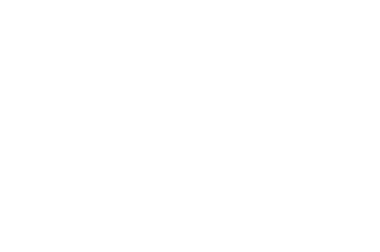

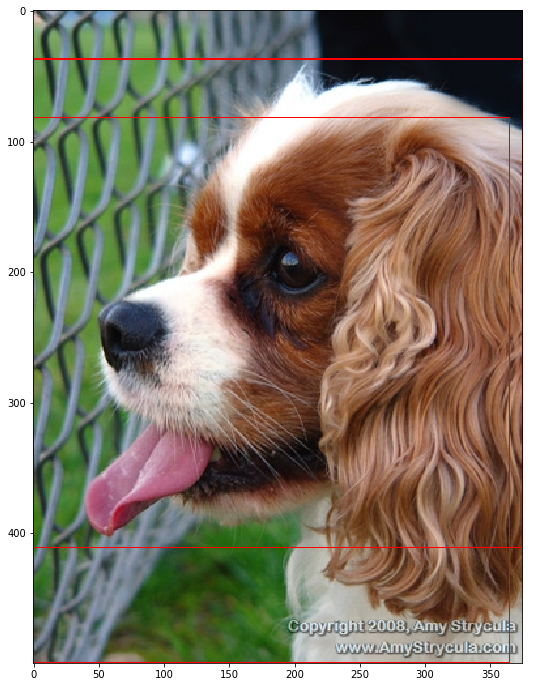

In [45]:
            if cls[j] == class_object and name[0] in fn:
                gt = ground_truth[j]
                idx = fn.index(name[0])
                box_ = torch.from_numpy(box[idx][:4]).float()
                #box_ = Projection(box_, img, feature)
                box_img = Transition(box_, img)
                deltas = reg(roi_pooling(Extractor(Variable(box_img).cuda())).view(-1))
                targets = bbox_transform(box_, gt).cuda()
                optimizer_b.zero_grad()  
                loss_b= criterion(deltas, targets)
                loss_b.backward()
                optimizer_b.step()
                
                def bbox_transform_inv(boxes, deltas):
    boxes = boxes.numpy()
    deltas = deltas.data.cpu().numpy()
    
    if boxes.shape[0] == 0:
        return np.zeros((0, deltas.shape[1]), dtype=deltas.dtype)

    #boxes = boxes.astype(deltas.dtype, copy=False)
    widths, heights, ctr_x, ctr_y = _whctrs(boxes)

    dx = deltas[0]
    dy = deltas[1]
    dw = deltas[2]
    dh = deltas[3]

    pred_ctr_x = dx * widths + ctr_x
    pred_ctr_y = dy * heights + ctr_y
    pred_w = np.exp(dw) * widths
    pred_h = np.exp(dh) * heights
    #--------corresponding to coordinates-------#
    pred_boxes = np.zeros(deltas.shape, dtype=deltas.dtype)
    pred_boxes[0] = pred_ctr_x - 0.5 * pred_w
    pred_boxes[1] = pred_ctr_y - 0.5 * pred_h
    pred_boxes[2] = pred_ctr_x + 0.5 * pred_w
    pred_boxes[3] = pred_ctr_y + 0.5 * pred_h
    return pred_boxes

def bbox_transform(ex_rois, gt_rois):
    ex_rois = ex_rois.numpy()
    ex_widths, ex_heights, ex_ctr_x, ex_ctr_y = _whctrs(ex_rois)
    
    gt_rois = gt_rois.numpy()
    gt_widths, gt_heights, gt_ctr_x, gt_ctr_y = _whctrs(gt_rois)

    targets_dx = (gt_ctr_x - ex_ctr_x) / ex_widths
    targets_dy = (gt_ctr_y - ex_ctr_y) / ex_heights
    targets_dw = np.log(gt_widths / ex_widths)
    targets_dh = np.log(gt_heights / ex_heights)

    targets = np.vstack(
        (targets_dx, targets_dy, targets_dw, targets_dh)).transpose()

    return targets

In [11]:
def PlotBoxes(name, img_record, color, mode = '0'):
    img = Image.open(img_dir + '/' + name[0])
    Step = len(img_record)
    box = np.zeros([Step, 4])
    for i in xrange(Step):
        box[i] = img_record[i][:4]
    plt.axis('off')
    plt.figure(figsize=(12 , 12))
    draw = ImageDraw.Draw(img)
    for i in range(Step):
        box_ = (box[i][0], box[i][1], box[i][2], box[i][3])
        draw.rectangle(box_, outline = color)  
    #draw.rectangle((0,0, box[2], box[3]), outline = 'red')  
    plt.imshow(img)
    plt.show()
    

[[  0.00000000e+00   0.00000000e+00   3.28390076e+02   3.88236145e+02
    5.13845459e-01   8.80481958e-01   1.20000000e+01]
 [  3.91620331e+01   4.91217575e+01   3.02379639e+02   3.66182861e+02
    5.85278861e-01   8.70269179e-01   1.20000000e+01]
 [  0.00000000e+00   6.25000000e+01   3.74000000e+02   4.36500000e+02
    5.59717827e-01   8.60799730e-01   1.20000000e+01]
 [  1.24265633e+02   0.00000000e+00   3.74000000e+02   4.46885101e+02
    5.73423625e-01   8.52009118e-01   1.20000000e+01]
 [  6.15000000e+01   2.43999996e+01   3.74000000e+02   4.01233337e+02
    5.83760084e-01   8.45879674e-01   1.20000000e+01]
 [  7.42803345e+01   1.49295029e+02   3.74000000e+02   4.99000000e+02
    5.90839093e-01   7.46776938e-01   1.20000000e+01]
 [  1.21269333e+02   1.31230423e+02   2.51679688e+02   2.61640778e+02
    1.75868765e-01   6.28335774e-01   1.20000000e+01]
 [  0.00000000e+00   1.49295029e+02   3.11732544e+02   4.99000000e+02
    5.51287751e-01   5.93797386e-01   1.20000000e+01]
 [  1.01

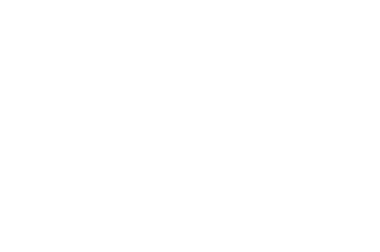

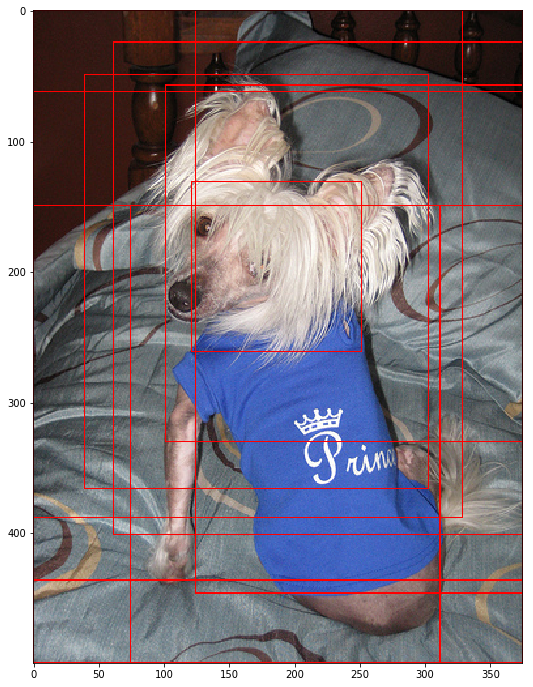

RuntimeError: dimension out of range (expected to be in range of [-1, 0], but got 1)

In [22]:
def GetBox(fn, gt,cls):
    record = data[fn]
    num = len(record)
    pack = np.zeros((num,7))
    r = np.zeros(gt.size(0))
    for i in range(num):
        pack[i][:6] = record[i]
        box = np.expand_dims(pack[i][:4], axis=0)
        iou, deltas, loc = IoUList(box, gt, r)
        pack[i][6] = cls[np.argmax(iou)]
    return pack

img, pack, fn = next(iter(train_batch))
num = int(pack.size(1) / 5)
ground_truth = torch.FloatTensor(num, 4)
cls = torch.LongTensor(num)
pack = pack.squeeze(0)
#-----record the gt and cls------#
for j in xrange(num):
    ground_truth[j] = pack[5*j: 5*j+4].clone()
    cls[j] = pack[5*j+4]
if fn[0] in data.keys():
    c = GetBox(fn[0], ground_truth, cls)
    print c

PlotBoxes(fn, c, 'red')
im_shape = np.array([img.size(3), img.size(2)])
f = vgg.features(Variable(img).cuda())
box = c[:, :4]
box = NMS(box, 0.3)
for i in range(box.shape[0]):
    box_img = GetFeature(box[i], f)
    output = F.softmax(vgg.classifier(box_img))
    score, label = torch.max(output.data.cpu(), 1)
    print image_sets[label.cpu().numpy()[0]], score.cpu().numpy()[0]

In [16]:
print output.cpu().data
#PlotBox1(fn, box, 'green')


 7.1233e-10
 2.0846e-08
 8.8583e-07
 9.9991e-01
 2.3089e-07
 5.4660e-07
 1.7217e-09
 5.1304e-06
 4.6882e-06
 1.7864e-07
 1.3641e-06
 2.7824e-07
 1.9486e-07
 8.3506e-07
 1.4316e-08
 6.5489e-05
 9.4515e-06
 3.0112e-06
 2.8430e-08
 3.6915e-09
 1.5726e-08
[torch.FloatTensor of size 21]



In [ ]:
roi_pooling = nn.AdaptiveAvgPool2d((3, 3))
#epoch_his = np.zeros(5)
iou_his = []
model = torch.load('./checkpoints/aeroplane/plane49.pth')
boxclass = torch.load('./checkpoints/aeroplane/plane_cls49.pth')
#reg = torch.load('reg' + str(i) +'.pth')
epoch_record = []
for step, (img, pack, fn) in enumerate(test_batch):
    #img_e = Image.open(img_dir + '/' +fn[0])
    num = int(pack.size(1) / 5)
    #----parameters initializing-----------#
    masked = None
    terminal = 0.
    available_ob = np.ones(num)
    ground_truth = torch.FloatTensor(num, 4)
    cls = torch.LongTensor(num)
    pack = pack.squeeze(0)
    im_shape = np.array([img.size(3), img.size(2)])
    feature = Extractor.forward(Variable(img).cuda())
    feature_shape = np.array([feature.size(3), feature.size(2)])
    img_record = []
    #-----record the gt and cls------#
    for j in xrange(num):
        ground_truth[j] = pack[5*j: 5*j+4].clone()
        cls[j] = pack[5*j+4]
    #--------for every object---------#
    """for j in range(num):
        if cls[j] == 1:"""
    Step = 0
    history_vector = np.zeros((num_his, action_dim))     
    #box_ = torch.FloatTensor([0, 0, img.size(3), img.size(2)]) #Initial box_
    box_ = Initial(img, num, fn)
    PlotBox(fn, box_, 'red')
    #s = GetState(box_, history_vector, feature)
    """record = np.zeros(num)
    Trigger = None
    new_iou, record = IoUList(box_, ground_truth, record)
    record = new_iou      
    box_img = roi(Extractor(Variable(Transition(box_, img)).cuda())).view(-1)
    score = boxclass.forward(box_img)
    img_record.append([box_.numpy(), max(record), score[0].data[0]])
    while(Trigger is None and Step < max_step and terminal == 0.):
        output = model.forward(s)
        action = torch.max(output.data, 1)[1].cpu().numpy()[0]
        box, Trigger, masked = Generate(action, box_.squeeze(0))
            #-------update history vector----#
        box = Clip_boxes(box.squeeze(0), im_shape)
        box_img = Transition(box, img)
        s2, r, img, terminal, record, history_vector, Step = Sample(box.squeeze(0), \
                                                        img, Trigger,  action, history_vector, record, Step)
        box_ = box.clone()
        s = s2
        box_img = roi(Extractor(Variable(Transition(box_, img)).cuda())).view(-1)
        score = boxclass.forward(box_img)
        img_record.append([box_.numpy(), max(record), score[0].data[0]])
        if terminal == 1. or action == 9:
            result = FindMax(img_record)
            #cls_score = vgg.forward(Variable(Transition(img, result[:4])))
            PlotInter(fn, img_record)
            epoch_record.append([fn[0], result])"""
#epoch_his[i-1] = np.mean(iou_his)
#WriteRecord(epoch_record,1, 'test_')

#print ('mean max IoU: {}'.format(Mean(epoch_record)))
#print np.mean(iou_his)

In [ ]:
print box_

In [ ]:
def as_num(a):
    y = '{:.6f}'.format(a)
    return y

def WriteComp3(epoch_record):
    f = open('./checkpoints/plane_val_comp3.txt', 'a')
    for i in range(len(epoch_record)):
        name, result = epoch_record[i]
        f.write(name + ' ')
        box = result[0:4]
        iou = result[4]
        score = result[5]
        f.write(str(as_num(score)))   
        for num in box:
            f.write(' '+str(as_num(num)))
        f.write('\n')
WriteComp3(epoch_record)

In [ ]:
print box

In [ ]:
result = FindMax(img_record)
cls_score = vgg.forward(Variable(Transition(result[:4], img)).cuda())
print F.softmax(cls_score)

In [ ]:
#regression training for the result of epoch 4
with open('plane_test_2.txt') as f:
    name = f.readlines()
fn=[]
num = 159
box = np.zeros([num, 6])
i = 0
for line in name:
    fn.append(line.split(' ')[0])
    num = line.split(' ')[1]
    box[i] = np.fromstring(num, dtype=float, sep=',')
    i += 1
reg = BboxReg(4608).cuda()
criterion = nn.MSELoss()
optimizer_b = torch.optim.SGD(reg.parameters(), lr=0.0001)  
roi_pooling = nn.AdaptiveAvgPool2d((3, 3))
for epoch in xrange(50):
    for i, (img, pack, name) in enumerate(test_batch):
        num = int(pack.size(1) / 5)
        ground_truth = torch.FloatTensor(num, 4)
        cls = torch.LongTensor(num)
        pack = pack.squeeze(0)
        for j in xrange(num):
            ground_truth[j] = pack[5*j: 5*j+4].clone()
            cls[j] = pack[5*j+4]
        im_shape = np.array([img.size(3), img.size(2)])
        feature = Extractor.forward(Variable(img).cuda())
        feature_shape = np.array([feature.size(3), feature.size(2)])
        #--------for every object---------#
        for j in xrange(num):
            if cls[j] == class_object and name[0] in fn:
                gt = ground_truth[j]
                idx = fn.index(name[0])
                box_ = torch.from_numpy(box[idx][:4]).float()
                #box_ = Projection(box_, img, feature)
                box_img = Transition(box_, img)
                deltas = reg(roi_pooling(Extractor(Variable(box_img).cuda())).view(-1))
                targets = bbox_transform(box_, gt).cuda()
                optimizer_b.zero_grad()  
                loss_b= criterion(deltas, targets)
                loss_b.backward()
                optimizer_b.step()
    if epoch > 0 and epoch % 10 == 0:
        torch.save(reg, 'plane_reg' + str(epoch / 10) + '.pth')
        print loss_b.data[0]
        #WriteRecord(epoch_record,i / 10)
torch.save(reg, 'plane_reg5.pth')
print loss_b.data[0]

In [ ]:
def NMS(box):
    box=box[box[:,5].argsort()]
    mbox = box[-1][:4]
    for i, item in enumerate(box):
        if IoU(item, mbox) > thre:
            del box[i]
    return box

In [ ]:
#regression training for the result of epoch 4
with open('plane_test_2.txt') as f:
    name = f.readlines()
fn=[]
num = 159
box = np.zeros([num, 6])
i = 0
for line in name:
    fn.append(line.split(' ')[0])
    num = line.split(' ')[1]
    box[i] = np.fromstring(num, dtype=float, sep=',')
    i += 1
    
iou_record = []
reg_record = []
reg = torch.load('plane_reg5.pth')
for i, (img, pack, name) in enumerate(test_batch):
    num = int(pack.size(1) / 5)
    im_shape = np.array([img.size(3), img.size(2)])
    ground_truth = torch.FloatTensor(num, 4)
    cls = torch.LongTensor(num)
    pack = pack.squeeze(0)
    for j in xrange(num):
        ground_truth[j] = pack[5*j: 5*j+4].clone()
        cls[j] = pack[5*j+4]
    #--------for every object---------#
    for j in xrange(num):
        if cls[j] == class_object and name[0] in fn:
            img_e = Image.open(img_dir + '/' + name[0])
            gt = ground_truth[j]
            idx = fn.index(name[0])
            box_ = torch.from_numpy(box[idx][:4]).float()
            #box_ = Projection(box_, img, feature)
            iou = box[idx][4]
            box_img = Transition(box_, img)
            deltas = reg(roi_pooling(Extractor(Variable(box_img).cuda())).view(-1))
            bbox_pred = bbox_transform_inv(box_.squeeze(0), deltas)
            bbox_pred = Clip_boxes(bbox_pred, im_shape)
            new_iou = IoU(bbox_pred, gt)
            iou_record.append(iou)
            reg_record.append(new_iou)
            #iou_record.append(max(iou, new_iou))
            if iou> new_iou:
                PlotBox(img_e, box_, 'red')
            else:
                PlotBox(img_e, bbox_pred, 'red')
                #PlotBox(img_e, Projection(box.squeeze(0), img, feature),  'black')
            #print ('name: {}, before: {}, after regression: {}'.format(fn[idx], iou, new_iou))
            break
print np.mean(iou_record), np.mean(reg_record)
"""img_e = Image.open(img_dir + '/' + fn[0])
PlotBox(img_e, ground_truth[j], 'red')
PlotBox(img_e, Projection(box.squeeze(0), img, feature),  'black')"""